# **Deep Learning For Lung Cancer Prediction Based on Transcriptomic Data**
> Author : **Aymen MERROUCHE**. <br>
> In this notebook, we explain the procedure to retrieve, transform and load the transcriptomic (gene-expression data) data for our deep learning models. Moreover, we describe the mechanisms used to deal with the **class imbalance** that we face, namely: **oversampling** and the use of the **focal loss**. Finally, we expose our contributions and what motivated them: **the use of the focal loss**,  **VAE learned embeddings** and **Investigating the quality of the gene expression images**.

## **1 - Download and Transform the Data :**
> In this work, we are interested in predicting survival outcome for lung cancer. We make use of a subset composed of thousands of gene-expression samples from thirty-one tumor types from the public **PanCancer** dataset to pre-train the models. Then, in a **transfer learning** fashion, we fine tune the models on lung cancer samples to predict cancer progression-free interval (fixing a threshold on this time intervall, it boils down to a binary classification task). The transcriptomic data is used in two forms:
> * **Traditional transcriptomic data:** RNA-seq gene expression samples (vectors), used to train bentchmarks. 
> * **Gene Expression Images:** The gene-expression vectors contained in the PanCancer dataset are transformed into images, by rearranging the gene-expression vectors using the KEGG BRITE hierarchical information. Applying CNNs directly on gene-expression vectors is not possible due the unstructured nature of this data. This transformation puts together genes that share domain-specific information thus providing them with some structure and allowing the use of CNNs.<br>

> For more information on how the data is transformed (the procedure to get the gene-expression images) and cleaned (feature selection) please refer to the original article which introduced the approach: [Transfer learning with convolutional neural networks for cancer survival prediction using gene-expression data](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0230536). <br>
> The code to download, clean and transform the data is provided in the image_generation folder (execute the notebooks sequentially. The notebooks are in python and in R). The code is directly adapted from the github of the authors of the article mentioned above [click here](https://github.com/guilopgar/GeneExpImgTL/tree/f079d354dc8f25d4e908782a382f90a24413b5f4).

## **2 - The Datasets :**
> We provide an implementation of pytorch datasets for the different datasets used (vectors for lung and non lungs samples and images for lung and non lung samples). They are available in the data_utils.py file, you only need to provide the paths to the files generated in the previous section.

In [1]:
# Import the datasets
from data_utils import *
import seaborn as sns
sns.set_style()
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# paths to the files generated in the previous section
path_to_pan_cancer_hdf5_files = "/tempory/transcriptomic_data/pan_cancer"
path_to_treemap_images = "/tempory/transcriptomic_data/images"

### **2 - 1 - The gene-expression images dataset :**

In [3]:
%%time
# dataset for Non Lung cancer gene expression images
non_lung_images_dataset = TranscriptomicImagesDatasetNonLung(path_to_pan_cancer_hdf5_files, path_to_treemap_images)
# dataset for Lung cancer gene expression images
lung_images_dataset = TranscriptomicImagesDatasetLung(path_to_pan_cancer_hdf5_files, path_to_treemap_images)

CPU times: user 3.77 s, sys: 1.08 s, total: 4.86 s
Wall time: 11.7 s


In [4]:
print("Number of Non Lung Samples :", len(non_lung_images_dataset))
print("Number of Lung Samples :", len(lung_images_dataset))
print("Shape of the images :", list(lung_images_dataset[0][0].size()))

Number of Non Lung Samples : 7707
Number of Lung Samples : 855
Shape of the images : [1, 175, 175]


### **2 - 2 - The gene-expression vectors dataset :**

In [5]:
%%time
# dataset for Non Lung cancer gene expression vectors
non_lung_vectors_dataset = TranscriptomicVectorsDatasetNonLung(path_to_pan_cancer_hdf5_files)
# dataset for Lung cancer gene expression vectors
lung_vectors_dataset = TranscriptomicVectorsDatasetLung(path_to_pan_cancer_hdf5_files)

CPU times: user 24.5 s, sys: 497 ms, total: 25 s
Wall time: 26.9 s


In [6]:
print("Number of Non Lung Samples :", len(non_lung_vectors_dataset))
print("Number of Lung Samples :", len(lung_vectors_dataset))
print("Dimension of the Vectors :", list(lung_vectors_dataset[0][0].size())[0])

Number of Non Lung Samples : 7707
Number of Lung Samples : 855
Dimension of the Vectors : 7509


## **3 - Dealing With Class Imbalance :**
However, we need to be careful. Such medical datasets suffer from severe **class imbalance** with a high number of negative examples and a low number of positive examples, as shown in the bar plots below below (on the images dataset, however it still holds for the vectors as it is only the form of the transcriptomic data that changes not the labels):

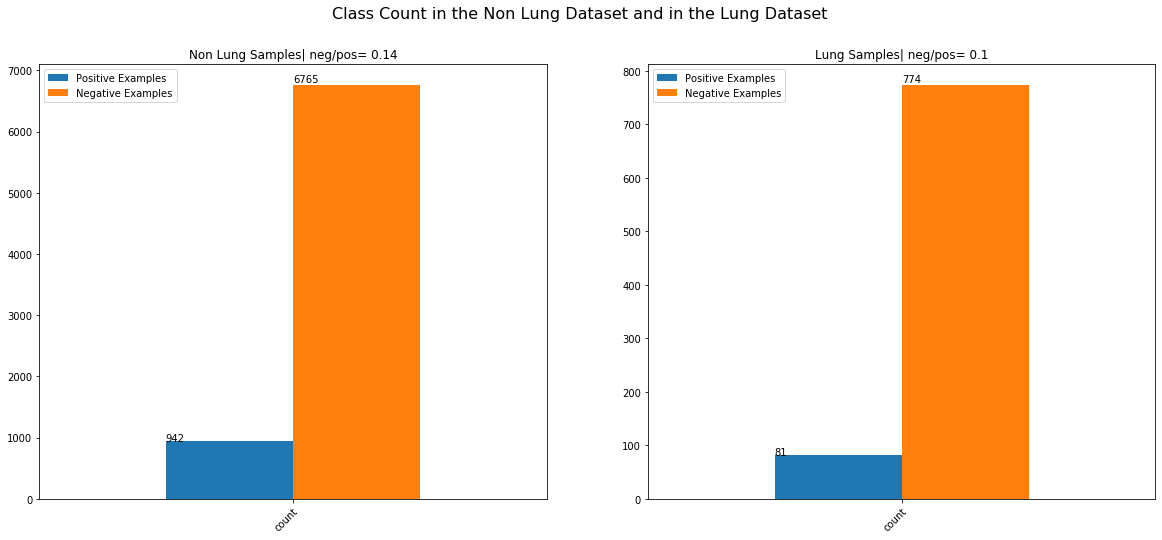

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
# Let's see how the classes are distributed across examples:
datasets_as_dict = {"Non Lung Samples" : non_lung_images_dataset, "Lung Samples": lung_images_dataset}
plt.figure(figsize=(20, 8))
plt.suptitle("Class Count in the Non Lung Dataset and in the Lung Dataset", fontsize=16)
for i,config in enumerate(datasets_as_dict):
    dataset = datasets_as_dict[config]
    class_count = dict(Counter(dataset.labels.numpy()))
    # plot the class repartition
    ax = plt.subplot(1, 2, i+1)
    rep_df = pd.DataFrame({"Positive Examples" : [class_count[1]], "Negative Examples" : [class_count[0]]}, index=["count"])
    rep_df.plot(ax=ax, kind="bar")
    ax.set_title(config+"| neg/pos= "+str(round(class_count[1]/class_count[0], 2)))
    # layout for the x labes
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    # also show the value on top of barplots
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig("./figs/class_count.png")

> We can see that the classes are severly imbalanced with $\frac{Positive Examples}{Negative Examples} < 0.15$. In such a context even a dummy model which always predicts $0$ will achieve an accuracy of $>85%$ :

In [8]:
from sklearn.metrics import accuracy_score
dumby_predictions = np.zeros(len(non_lung_images_dataset))
print("Accuracy When Predicting 0 for all Examples : ",accuracy_score(non_lung_images_dataset.labels.numpy(), dumby_predictions))

Accuracy When Predicting 0 for all Examples :  0.8777734527053328


> However when we see other metrics such as the $F_1$-score on the positive class, we understand that these predictions have no sense and that the accuracy metric is not informative in such a context:

In [9]:
from sklearn.metrics import classification_report
print(classification_report(non_lung_images_dataset.labels.numpy(), dumby_predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      6765
           1       0.00      0.00      0.00       942

    accuracy                           0.88      7707
   macro avg       0.44      0.50      0.47      7707
weighted avg       0.77      0.88      0.82      7707



> In our experimets, We use the **AUC metric** as a criterion to judge the quality of a model. Therefore **the best model is the one which achieves the best AUC score**. Generally speaking, an AUC $>0.7$ is considered acceptable.

In [10]:
# auc
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(non_lung_images_dataset.labels.numpy(), dumby_predictions, pos_label=1)
auc = metrics.auc(fpr, tpr)
print("AUC for the dummy model : ", auc)

AUC for the dummy model :  0.5


> The dummy model gets an AUC of $0.5$, which means that is has no discrimination ability.

## **To deal with this caveat we use two mechanisms while training our models:**

### **3 - 1 - Random Over Sampling :**
> We supplement the training data with copies of the negative class by randomly sampling, with replacement, learning examples from the different classes with a weight equal to the inverse of the class count. Hence, our learning batches contain roughly 50% of negative examples and 50% of negative examples. The get_data_loaders function in data_utils.py implements this using a sampler object that is passed to pytorch's dataloader. Let's see the class repartition in batches yielded by this method:

In [11]:
loader_train_images, _ = get_data_loaders(non_lung_images_dataset)
first_batch = next(iter(loader_train_images))

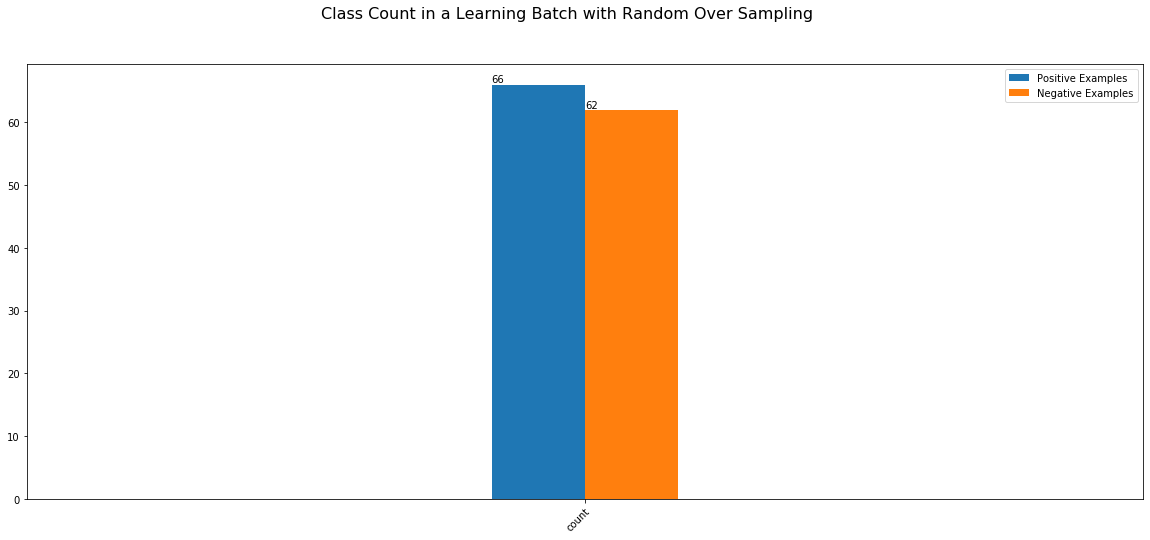

In [12]:
plt.figure(figsize=(20, 8))
plt.suptitle("Class Count in a Learning Batch with Random Over Sampling", fontsize=16)
class_count = dict(Counter(first_batch[1].numpy()))
# plot the class repartition
ax = plt.subplot(1, 1, 1)
rep_df = pd.DataFrame({"Positive Examples" : [class_count[1]], "Negative Examples" : [class_count[0]]}, index=["count"])
rep_df.plot(ax=ax, kind="bar", width=0.1)
# layout for the x labes
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
# also show the value on top of barplots
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))

### **3 - 2 - The Focal Loss :**

> The Focal Loss introduced in [link to original paper](https://arxiv.org/abs/1708.02002) is a very popular loss used when training dense object detectors where we face class imbalance (foreground-background class imbalance : a large number of background examples (negative examples i.e. examples with no objects to detect) and a low number of foreground examples (positive examples, examples with actual objects to detect)). In our case, as seen above, we also face class imbalance with a large number of negative examples associated with a small cross entropy loss and a low number of positive examples associated with a high cross entropy loss. When summed over a large number of easy examples, these small loss values can distract training when using the classic cross entropy loss. To deal with this caveat, we use the focal loss as a criterion when training our models. It is given by the formula : 
$$\textbf{FL}(p_t) = -\alpha_t(1 - p_t)^{\gamma}log(p_t)$$
where :
$$
p_t = \begin{cases} 
p & \mbox{if } y = 1 \\
1 - p & \mbox{otherwise} 
\end{cases}
\mbox{ and } 
\alpha_t = \begin{cases} 
\alpha & \mbox{if } y = 1 \\
1 - \alpha & \mbox{otherwise} 
\end{cases}
$$

> <img src=./figs/focal_loss.png>

> $\alpha_t$ balances the importance of negative and positive examples, however it doesn't differentiate between hard and easy examples. A modulating factor $(1-p_t)^{\gamma}$ is introduced for this effect. <br>
As shown in the figure above, for misclassified examples where $p_t$ is low, $(1-p_t)^{\gamma}$ is near $1$, whereas as $p_t \rightarrow 1$ this factor goes to $0$ thus down-weighting easy examples. $\gamma$ -the focusing parameter- controls the rate at which easy examples are down-weighted. <br>
**The focal loss down-weighs the loss accorded to easy examples so that their contribution to the total loss remains low even if their number is large** allowing the model to focus on hard examples during training preventing it from being overwhelmed by the large number of negative examples. <br>
Both $\alpha$ and $\gamma$ are hyperparameter, we set them to $0.5$ (since we already do ROS) and $3$ respectively, in our experiments. <br><br>
> The implementation of this loss is in the modules folder, focal_loss.py.

## **4 - Contributions : What and Why ?**
> The main goal of this project is to explore what deep learning has to offer when it comes to exploiting gene-expression data. To this purpose, different deep learning approaches were tested, compared and then confronted with traditional Machine Learning algorithms: we foud that deep learning approaches outperformed traditional Machine Learning Approaches. Moreover, my contributions are the following:

### **4 - 1 - The use of the focal loss :**
> The focal loss as introduced above, was used to train our models. This loss has shown it's efficiency when training dense object detectors. It fights more effectively against class imbalance. By allowing the model to focus on hard examples, it's use resulted in a faster and more stable convergence of the models when compared to the classical cross entropy loss.

### **4 - 2 - Learning Embeddings with Variational Autoencoders :**
> As shown in our different experiments, transfer learning (pre training on the Non Lung Cancer Samples) allowed to avoid overffiting (our Lung Cancer dataset is extremely small $1000k$ and high dimentional ($175 \times 175$ for the gene-expression images and $7509$ for the gene-expression vectors) especially since we training Deep Learning Models and we know that these models show their full potential with large datasets). However, one may ask the question, **what if we don't have transfer learning data, what if transfer learning is not possible ?**. To this end, we proposed the use of variational autoencoders to learn high level feature embeddings using only the Lung cancer data. As shown in our experiments, this approach achieved the highest AUC score between our models (both deep and non deep). VAEs wrok as follows :

> Variational Auto-encoders are generative models with explicit approximated density (we compute an approximation of $p(x)$). Let's suppose that we have the data $x_i \sim p_{data}$, and that we want to sample from $p_{data}$. The idea, similarily to generative adversarial networks, is to introduce a latent variable $z$, however the reasoning to sample from $p_{data}$ is different.


> The hypothesis that is done when training VAEs is that the data $\{x_i\}_{1 \leq i \leq N} \sim p_{data}$ is generated from an unobserved latent variable $z$ which follows a prior $p(z)$. Consequently, to sample from $x \sim p_{data}$, we only need to :
> * Sample $z \sim p(z)$.
> * Sample $x$ from $p_{\theta}(x | z)$.


>The goal is then to maximize the likelihood of the data $p_{\theta}(x)$. However, this formulation is not conceivable, because to obtain $p_{\theta}(x)$ two alternatives are possible :
> * Marginalise : $p_{\theta}(x) = \int_{z} p_{\theta}(x, z)dz = \int_{z} p_{\theta}(x|z)p_{\theta}(z)dz$, this is not computable ($z$ is unobserved).
> * Bayes Rule : $p_{\theta}(x) = \frac{p_{\theta}(x|z)p_{\theta}(z)}{p_{\theta}(z|x)}$, and we don't have $p_{\theta}(z|x)$.


> The solution is then to train a network to approximate $p_{\theta}(z|x)$ by $q_{\phi}(z|x)$. Then, we can approximate the likelihood $p_{\theta}(x)$, by what we call the "Variational Lower Bound" given by:
$$\log{p_{\theta}(x)} \geq \mathbb{E}_{z \sim q_{\phi}(z|x)}[log(p_{\theta}(x|z)] - dkl(q_{\phi}(z|x), p(z))$$
By maximizing this lower bound, we hope to maximise the likelihood.


> The final architecture is composed of two networks:
> * An **Encoder**, with input $x_i \sim p_{data}$,it yields the distribution $q_{\phi}(z|x) = N(\mu_{z | x}, \Sigma_{z | x})$.
> * A **Decoder** , which takes latent codes $z$ as an input, and yields the distribution $p_{\theta}(x|z)$


> These two networks are jointly trained as follwos :
> * 1 - Feed the encoder with input $x_i$, and get a distribution on the codes $z$.
> * 2 - Sample $z$ from the distribution from $1$.
> * 3 - feed the codes  $z_i$ sampled in 2 to the decoder to get a distribution on the data $x_i$.
> * 4 - Minimize the variational lower bound, which consists of two terms:
    * $dkl(q_{\phi}(z|x), p(z))$ : the distribution outputted by the encoder should be close to the prior $p(z)$, it's a regularization term.
    *  $\mathbb{E}_{z \sim q_{\phi}(z|x)}[log(p_{\theta}(x|z)]$ : The data $x_i$ are likely under the distribution outputted by the decoder. It's a reconstruction term.

> Contrarily to GANs, **VAEs don't only learn to generate data from $p_{data}$, they also learn to represent the data by the latent variables $z|x$. After training the network, we can use the encoder to get high level feature embeddings of our data.**

### **4 - 3 - Investigate the Quality of the Gene-Expression Images :**
> As mentioned earlier, gene-expression vectors are rearranged into gene-expression images following a biological criterion to give them some structure and allow the use on CNNs. 

> As shown in the experiments, transforming the gene-expression vectors into gene-expression images did allow CNNs to extract high-level features from the data and achieved equal performance with an MLP trained on gene-expression vectors. However this approach is still limited when compared to real image data.

> We tried to enhance the transformation modeling capacity of CNNs by using deformable convolution introduced in [Deformable Convolutional Networks
](https://arxiv.org/abs/1703.06211). which augments the spatial sampling locations of CNNs by learning the offsets. This method, although it has shown it’s effectiveness on traditional computer vision tasks, achieved poor performances on our gene-expression images with no generalization ability.Therefore, we can say that the image representation is still inheritably unstructured (from the unstructured nature of gene-expression data) and doesn't leverage the performances achieved when using real images.


### **4 - 4 - Implementation Details:**
> * The image generation procedure is adapted from this repository [click here](https://github.com/guilopgar/GeneExpImgTL/tree/f079d354dc8f25d4e908782a382f90a24413b5f4)
(the original article which introduced the approach).
> * Deformable convolution is inspired adapted from an existing implementation [click here](https://github.com/oeway/pytorch-deform-conv).
> * **Other than that all modules and notebooks (including training procedures) are coded from scratch.**